In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.chdir("../") # Going one folder above

In [2]:
import portfolio_methods
import portfolio_optimizer as po
import json
import sys
import datetime as dt
import numpy as np
import universe
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from seaborn import distplot
from portfolio import Portfolio, PM, StrategyPortfolio
import universe
from backtester import Backtester
font = {'size'   : 15}
matplotlib.rc('font', **font)
matplotlib.style.use('bmh')
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [3]:
etfs = json.load(open("jsons/tutorial_etfs.json", "r"))
stocks = json.load(open("jsons/tutorial_portfolio.json", "r"))

In [4]:
# uniting the dictionaries
etfs['TIME_SERIES_DAILY_ADJUSTED'].update(stocks['TIME_SERIES_DAILY_ADJUSTED'])
total = etfs

In [5]:
total

{'TIME_SERIES_DAILY_ADJUSTED': {'IWV': {},
  'SPY': {},
  'QQQ': {},
  'OILU': {},
  'AAPL': {},
  'GOOG': {},
  'AMD': {},
  'NVDA': {},
  'CLVS': {}}}

In [6]:
assets = portfolio_methods.PortfolioMethods._flatDict(total)

# Making a universe object
universeObj = universe.Universe(assets, ("RISK_FREE", "USA"))
universeObj.setFrequency('1D')
universeObj.setCAPMFactors([("TIME_SERIES_DAILY_ADJUSTED", "SPY")])
universeObj.setDateRange(start='2017-10-22', end='2019-11-22')
print(len(PM.cachedAssets))

Loading size:  9
Loading size:  1
[Allocated value]:  9.0
10


In [7]:
# Defining your strategy function
# Signature: receive universe and kwdict (other variables you might want to pass)
# Signature: return assets, allocation, direction, {}
# This function selects the highest sharpe assets in the period and return
# This is a vol momentum strategy (might not make any sense, just to illustrate)
# We will feed this function to the backtester
def selectHighestVolWithVolConstraint(universeObj, kwdict):
    rets = universeObj.data['assetsReturnOnFreq'].mean()
    vols = universeObj.data['assetsReturnOnFreq'].std()
    volMkt = universeObj.data['factorsReturnOnFreq'].std()

    data = pd.DataFrame(vols, columns=['vol'])
    data['var'] = vols ** 2
    
    volMask = data['vol'] > volMkt.values[0]/10 # Constraint, only accept assets with vol higher than 1/10 of the market's vol
    select = data[volMask]
    select = select.sort_values('vol', ascending=False)
    
    # 3 assets at the time
    total = 3
    assets = list(select.head(total).index)
    portfolio = data.loc[assets]
    # 1 over vol weight
    weight = 1.0/portfolio['vol']
    allocation = weight/weight.sum()
    direction = np.ones(len(portfolio))
    return assets, allocation, direction, {}

In [8]:
# Setup backtest, it will use the parameters of universeObj
backtester = Backtester(universeObj)

In [9]:
# Backtesting
# Rebalance every 90 days, with strategy "selectHighestVolWithVolConstraint"
# and give to the function 180 days of data (past days, out of sample always)
history = backtester.backtest(selectHighestVolWithVolConstraint, 30, daysBeforeVisibility=180, inverse=False)

Loading universe data from 2017-04-25 to 2019-11-22.
Finished 'make' in 0.2380 secs
Backtesting from 2017-10-22 to 2019-11-22

[BACKTESTER]: Running strategy with data from: 
 2017-04-25 to 2017-10-22
[BACKTESTER]: Checking Portfolio from: 
 2017-10-22 to 2017-11-22

Loading size:  0
Loading size:  0
[Allocated value]:  1.0000000596046448
Finished 'make' in 0.0326 secs

[PORTFOLIO SUMMARY]
[FROM]:  2017-10-22
[TO]:  2017-11-22

Sharpe ratio:  -0.43819353694392943
Alpha:  [-0.66600617]
Beta:  [[3.35970234]]
Expected:  -0.1559963459149003
Annualized return:  -0.22132625248561533
Vol:  0.3802840164896
Vol Idio:  0.3192725051959821
Total Return:  -0.020351409912109375
Information Ratio:  -14.021294925717736
Vol ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  0.05806224743392651
Sharpe ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  2.636648371944026
Cumreturn factors:              (TIME_SERIES_DAILY_ADJUSTED, SPY)
2017-11-22                           0.014252
Max 1y DD:  -0.09541685940591038
Avg last 5 1y

Finished 'make' in 0.0354 secs

[PORTFOLIO SUMMARY]
[FROM]:  2018-08-02 00:00:00
[TO]:  2018-09-03

Sharpe ratio:  3.4054324865477903
Alpha:  [0.67589978]
Beta:  [[1.54657722]]
Expected:  1.162670200690627
Annualized return:  2.3604506408132617
Vol:  0.34557015453011025
Vol Idio:  0.32102293686367195
Total Return:  0.10109138488769531
Information Ratio:  40.47766721927542
Vol ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  0.06919555885964415
Sharpe ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  4.531761735999899
Cumreturn factors:              (TIME_SERIES_DAILY_ADJUSTED, SPY)
2018-08-31                           0.028046
Max 1y DD:  -0.07641947269439697
Avg last 5 1y DD:  -0.07091069221496582


[BACKTESTER]: Running strategy with data from: 
 2018-03-07 to 2018-09-03
[BACKTESTER]: Checking Portfolio from: 
 2018-09-03 to 2018-10-04

Loading size:  0
Loading size:  0
[Allocated value]:  1.0000000596046448
Finished 'make' in 0.0403 secs

[PORTFOLIO SUMMARY]
[FROM]:  2018-08-31 00:00:00
[TO]:  2018-10

Finished 'make' in 0.0400 secs

[PORTFOLIO SUMMARY]
[FROM]:  2019-06-13 00:00:00
[TO]:  2019-07-15

Sharpe ratio:  3.4986748948512862
Alpha:  [0.29008746]
Beta:  [[2.37912123]]
Expected:  1.4416640773415565
Annualized return:  2.8519667355408926
Vol:  0.4174989363717033
Vol Idio:  0.3662168051171723
Total Return:  0.1255052089691162
Information Ratio:  38.66589160515356
Vol ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  0.07729277269286049
Sharpe ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  6.3285147201958925
Cumreturn factors:              (TIME_SERIES_DAILY_ADJUSTED, SPY)
2019-07-15                            0.04363
Max 1y DD:  -0.0646242135180447
Avg last 5 1y DD:  -0.05065374353719356


[BACKTESTER]: Running strategy with data from: 
 2019-01-16 to 2019-07-15
[BACKTESTER]: Checking Portfolio from: 
 2019-07-15 to 2019-08-15

Loading size:  0
Loading size:  0
[Allocated value]:  1.0000000298023224
Finished 'make' in 0.0414 secs

[PORTFOLIO SUMMARY]
[FROM]:  2019-07-15 00:00:00
[TO]:  2019-08-1

In [10]:
# Make a strategy portfolio by composing many portfolios through time
pi = StrategyPortfolio(history)

Loading size:  0
Loading size:  0
[Allocated value]:  3.0


//anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


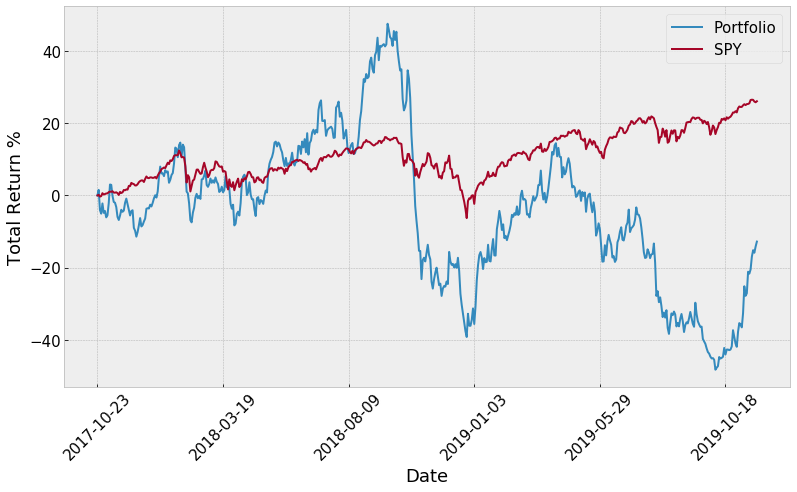

In [11]:
rets = pi.plot()

In [12]:
summ = pi.summarize()


[PORTFOLIO SUMMARY]
[FROM]:  2017-10-22
[TO]:  2019-11-22

Sharpe ratio:  0.0781996218751782
Alpha:  [-0.15452525]
Beta:  [[1.77363715]]
Expected:  0.051257271277133955
Annualized return:  -0.06362327857246941
Vol:  0.4844056173364383
Vol Idio:  0.40845346719961884
Total Return:  -0.12792328313445855
Information Ratio:  -2.6422389100966743
Vol ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  0.14648427326557575
Sharpe ('TIME_SERIES_DAILY_ADJUSTED', 'SPY'):  0.7411309477739084
Cumreturn factors:              (TIME_SERIES_DAILY_ADJUSTED, SPY)
2019-11-22                           0.261011
Max 1y DD:  -0.6228087817925014
Avg last 5 1y DD:  -0.6171543520803973



In [13]:
# In this case it didnt change much since CLVS, AMD, OILU had the highest volatility through all period
# But as you can see the allocations change through time, as expected since the values change
history

OrderedDict([(datetime.date(2017, 10, 22),
              {'assets': [('TIME_SERIES_DAILY_ADJUSTED', 'CLVS'),
                ('TIME_SERIES_DAILY_ADJUSTED', 'OILU'),
                ('TIME_SERIES_DAILY_ADJUSTED', 'AMD')],
               'n_assets': 3,
               'allocation': (TIME_SERIES_DAILY_ADJUSTED, CLVS)    0.290142
               (TIME_SERIES_DAILY_ADJUSTED, OILU)    0.306335
               (TIME_SERIES_DAILY_ADJUSTED, AMD)     0.403523
               Name: vol, dtype: float32,
               'direction': array([1., 1., 1.]),
               'pi': <portfolio.Portfolio at 0x1a2223b898>}),
             (datetime.date(2017, 11, 22),
              {'assets': [('TIME_SERIES_DAILY_ADJUSTED', 'CLVS'),
                ('TIME_SERIES_DAILY_ADJUSTED', 'OILU'),
                ('TIME_SERIES_DAILY_ADJUSTED', 'AMD')],
               'n_assets': 3,
               'allocation': (TIME_SERIES_DAILY_ADJUSTED, CLVS)    0.262864
               (TIME_SERIES_DAILY_ADJUSTED, OILU)    0.296000
       